<a href="https://colab.research.google.com/github/AntonioWanderer/CompPhys22/blob/main/Hopf_Equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Уравнение Хопфа: теория

# Постановка задачи

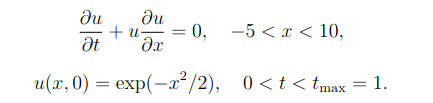

# Решение

In [1752]:
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import os, cv2
from math import *

In [1753]:
def graph3D(points, xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals, mkFrames=False, name="NoName", numFrames=50):
  fig = plt.figure()
  ax = plt.axes(projection='3d')
  ax_3d = fig.add_subplot(projection='3d')
  ax.set_xlabel("X, m")
  ax.set_ylabel("T, s")
  ax.set_zlabel("U, m/s")
  x = np.linspace(xFrom, xTo, xIntervals+1)
  t = np.linspace(timeFrom,timeTo,timeIntervals+1)
  X, Y = np.meshgrid(t, x)
  ax_3d.plot_wireframe(Y, X, points, color='black')
  plt.show()
  if mkFrames:
    print("Frames preparing...")
    if not os.path.exists(name+"_frames"):
      os.makedirs(name+"_frames")
    framesNames = []
    for ang in range(numFrames):
      ang = int(360/numFrames) * ang
      framesNames.append(str(ang))
      ax_3d.view_init(30, ang)
      fig.savefig(name+"_frames/" + str(ang)+".jpg", dpi = 300)
      fig.savefig(name+"_frames/" + str(ang)+".jpg", dpi = 300)
    mkVid(name+"_frames/", name, framesNames, 10)

In [1754]:
def graph2D(points, xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals, mkFrames = False, name="NoName"):
  fig = plt.figure()
  ax = plt.axes()
  ax.set_xlabel("X, m")
  ax.set_ylabel("U, m/s")
  dx = (xTo - xFrom) / xIntervals
  dt = (timeTo - timeFrom) / timeIntervals
  for t in range(timeIntervals + 1):
    xP = [xFrom + x * dx for x in range(xIntervals+1)]
    zP = [points[x, t] for x in range(xIntervals+1)]
    clr = hex(255+int(256**2/(timeIntervals+1)*t)-1)[2:]
    while len(clr) < 6:
      clr = "0" + clr
    ax.plot(xP, zP, color="#"+clr)
  plt.show()
  x0, x1 = ax.get_xlim()
  y0, y1 = ax.get_ylim()
  if mkFrames:
    print("Frames 2D preparing...")
    if not os.path.exists(name+"_frames"):
      os.makedirs(name+"_frames")
    framesNames = []
    for t in range(timeIntervals+1):
      framesNames.append(str(t))
      xP = [xFrom + x * dx for x in range(xIntervals+1)]
      zP = [points[x, t] for x in range(xIntervals+1)]
      ax.clear()
      ax.set_xlim(x0, x1)
      ax.set_ylim(y0, y1)
      ax.plot(xP, zP, color="g")
      fig.savefig(name+"_frames/" + str(t)+".jpg", dpi = 300)
      fig.savefig(name+"_frames/" + str(t)+".jpg", dpi = 300)
    mkVid(name+"_frames/", name, framesNames, timeTo-timeFrom)

In [1755]:
def TimeBoundaryCondition(xFrom, xTo, intervals):
  condition = np.zeros(intervals + 1)
  dx = (xTo - xFrom) / intervals
  for step in range(intervals + 1):
    x = xFrom + step * dx
    condition[step] = np.exp(-(x-1)**2 / 2)
    # if x>0:
    #   condition[step] = 0
    # else:
    #   condition[step] = 1
  return condition

In [1756]:
A1 = 1
B1 = 0
C1 = 0
A2 = 1
B2 = 0
C2 = 0

In [1757]:
def Explicit(uL, uM, uR, h, tau):
  result = uM *(uR - uL) * tau / (2 * h) + uM
  return result

In [1758]:
def Method3Diag(a, b, c, d, n):
    y = np.zeros(n+2)
    #forward
    for i in range(1, n+2):
        ksi = a[i]/b[i-1]
        a[i] = 0
        b[i] -= ksi * c[i-1]
        d[i] -= ksi * d[i-1]    
    #back
    y[n+1] = 2 * d[n+1] / b[n+1]
    
    for i in range(n, -1, -1):
        y[i] = 1/b[i] * (d[i] - c[i]*y[i+1])
    
    return y

In [1759]:
def SolvingHalf(n, h, tau, x):
  # 3-diagonal matrix preparing 
  a = - x /(4*h)
  b = np.ones(n+1) / tau 
  c = x / (4*h)
  d = np.array([0]+[x[i]*(1/tau+(x[i-1]-x[i+1])/(4*h)) for i in range(1, n)]+[0])

  b[0] = A1 - B1 / h
  c[0] = B1 / h
  d[0] = C1
  b[-1] = A2 - B2 / h
  c[-1] = B2 / h
  d[-1] = C2

  y = Method3Diag(a, b, c, d, n-1)
  return y

In [1760]:
def SolvingImplicit(n, h, tau, x):
  # 3-diagonal matrix preparing 
  a = - x /(2*h)
  b = np.ones(n+1) / tau 
  c = x/(2*h)
  d = x/tau

  b[0] = A1 - B1 / h
  c[0] = B1 / h
  d[0] = C1
  b[-1] = A2 - B2 / h
  c[-1] = B2 / h
  d[-1] = C2

  y = Method3Diag(a, b, c, d, n-1)
  return y

In [1761]:
def ComputeExplicit(xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals):
  solution = np.zeros((xIntervals + 1,timeIntervals + 1))
  solution[:,0] = TimeBoundaryCondition(xFrom, xTo, xIntervals)
  h = (xTo - xFrom) / xIntervals
  dt = (timeTo - timeFrom) / timeIntervals
  for t in range(timeIntervals):
    solution[0, t + 1] = solution[0, t]
    for x in range(1,xIntervals):
      solution[x, t + 1] = Explicit(solution[x+1, t], solution[x, t], solution[x - 1, t], h, dt)
    solution[-1, t + 1] = solution[-1, t]
  return solution

In [1762]:
def ComputeHalf(xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals):
  solution = np.zeros((xIntervals + 1,timeIntervals + 1))
  solution[:,0] = TimeBoundaryCondition(xFrom, xTo, xIntervals)
  h = (xTo - xFrom) / xIntervals
  dt = (timeTo - timeFrom) / timeIntervals
  for t in range(timeIntervals):
    solution[:,t+1] = SolvingHalf(xIntervals, (xTo-xFrom)/xIntervals, (timeTo-timeFrom)/timeIntervals, solution[:,t])
  return solution

In [1763]:
def ComputeImplicit(xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals):
  solution = np.zeros((xIntervals + 1,timeIntervals + 1))
  solution[:,0] = TimeBoundaryCondition(xFrom, xTo, xIntervals)
  h = (xTo - xFrom) / xIntervals
  dt = (timeTo - timeFrom) / timeIntervals
  for t in range(timeIntervals):
    solution[:,t+1] = SolvingImplicit(xIntervals, (xTo-xFrom)/xIntervals, (timeTo-timeFrom)/timeIntervals, solution[:,t])
  return solution

In [1764]:
def mkVid(path, name, framesNames, videoLength=10):
  print("Video rendering") 
  videoFps = int(len(framesNames)/videoLength)
  out = cv2.VideoWriter(name+".mp4",
                        cv2.VideoWriter_fourcc('m','p','4','v'),
                        videoFps,
                        (1800,1200))
  for i in framesNames:
    frame = cv2.imread(path + i + ".jpg")
    out.write(frame)
  out.release()
  cv2.destroyAllWindows()
  print("Done! Your video file is:\n"+name+".mp4")

In [1765]:
xIntervals = 1000
timeIntervals = 200
xFrom = -5
xTo = 10
timeFrom = 0
timeTo = 1

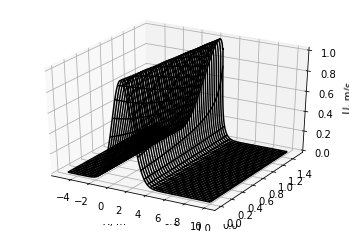

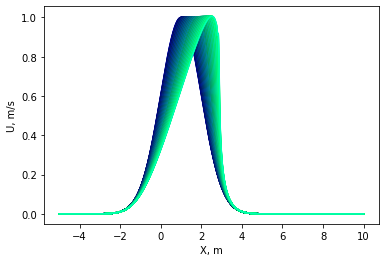

In [1766]:
pointsE = ComputeExplicit(xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals)
graph3D(pointsE, xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals, False)
graph2D(pointsE, xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals)

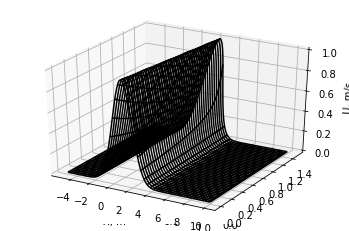

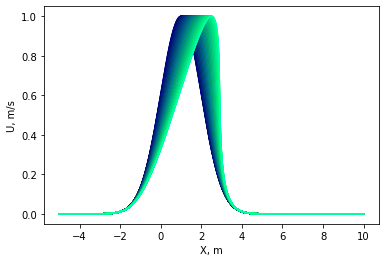

In [1767]:
pointsH = ComputeHalf(xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals)
graph3D(pointsH, xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals, False)
graph2D(pointsH, xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals)

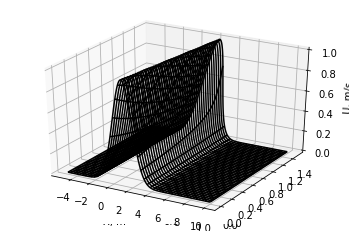

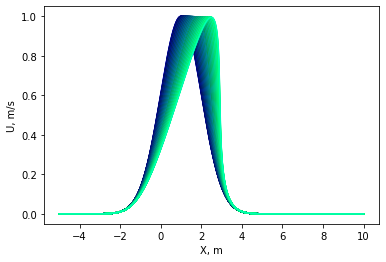

In [1768]:
pointsI = ComputeImplicit(xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals)
graph3D(pointsI, xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals, False)
graph2D(pointsI, xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals)

In [1769]:
framesToShow3d = 360

In [1770]:
nameString = "_"+str(timeFrom)+"-"+str(timeTo)+"s_"+str(xFrom)+"-"+str(xTo)+"m_"+str(xIntervals)+"x*"+ str(timeIntervals)+"t"
name3d = "3D" + nameString + str(framesToShow3d)
name2d = "2D" + nameString

In [1771]:
# graph3D(pointsE, xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals, True, "Explicit"+name3d, framesToShow3d)
# graph3D(pointsH, xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals, True, "Half"+name3d, framesToShow3d)
# graph3D(pointsI, xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals, True, "Implicit"+name3d, framesToShow3d)

In [1772]:
# graph2D(pointsE, xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals, True,"Explicit"+name2d)
# graph2D(pointsH, xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals, True,"Half"+name2d)
# graph2D(pointsI, xFrom, xTo, timeFrom, timeTo, xIntervals, timeIntervals, True,"Implicit"+name2d)

# Список литературы
https://keldysh.ru/papers/2018/prep2018_17.pdf